In [33]:
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

from matplotlib.pyplot import figure
import plotly.graph_objects as go

In [39]:
# set paths to dirs in data dir

path_data_dir = os.path.join(os.getcwd(), "data")

path_dialogs_meta_dir = os.path.join(path_data_dir, "dialogs_list")
path_dialogs_dir = os.path.join(path_data_dir, "dialogs")

path_to_dialogs_info = f"{path_data_dir}/all_dialogs_by_type.json"

USER_ID = 331192040

In [24]:
dialogs_info = {
    "Private dialog": {},
    "Group": {},
    "Channel": {}
}

# make dialogs_info dict: first level keys - "Channel", "Private dialog", "Group"
# second level items - "<name_of_dialog>": <id>
for file in os.listdir(path_dialogs_meta_dir):
    if file[-4:] == "json":
        with open(os.path.join(path_dialogs_meta_dir, file), "r", encoding="utf8") as meta_file:
            data = json.load(meta_file)

        dialogs_info[data["type"]][data["name"]] = data["id"]

# 1) save results
with open(path_to_dialogs_info, "w", encoding="utf-8") as f:
    json.dump(dialogs_info, f, indent=4, ensure_ascii=False)

## Plot of daily activity (09.08.2020)

In [36]:
# TODO: write such functions is a antipattern. 
# such code is a spagetti code
# you should: 1. decompose it on the simpler methods, 2. move all constants as (40 + 30) to the variables and comment logic behind them

def get_user_activity(dialogs_info, date_before, date_after, dialog_type, user_id_get_msg,
                      plot_type="daily_activity"):
    """

    :param dialogs_info: dict: first level keys - "Channel", "Private dialog", "Group"
    second level items - "<name_of_dialog>": <id>
    :param date_before: datetime type, from what time start to analyse msgs
    :param date_after: datetime type, to what time to analyse msgs
    :param dialog_type: "Channel" or "Private dialog" or "Group"
    :param plot_type: plot name for which you prepare your data
    :return: lists for a plot of "top_friends" or "daily_activity", depends on
    your input plot_type
    """
    dialog_active_minutes = 0

    plot_data = {}
    if plot_type == "daily_activity":
        for hour in range(24):
            if hour < 10:
                hour = '0' + str(hour)
                plot_data[hour] = 0
            else:
                plot_data[str(hour)] = 0

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        start_dialog_time, stop_dialog_time = 0, 0
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            print(dialog_id)
            continue

        dialog_data = pd.read_csv("data/dialogs/{}.csv".format(dialog_id))
        dialog_active_minutes_before = dialog_active_minutes
        flag_first_my_message = 0
        
        for row in dialog_data.index:
            if dialog_data["from_id"][row] == user_id_get_msg:

                date_time = dialog_data["date"][row][:-6]
                dialog_datetime = datetime.datetime.strptime(date_time,"%Y-%m-%d %H:%M:%S")
                
                # get previous message time for plot of "active_minutes" - number of minutes spending on
                # conversations during a day
                if flag_first_my_message == 0:
                    previous_message_time = dialog_datetime
                    flag_first_my_message = 1

                if dialog_datetime <= date_before:
                    break

                elif date_before < dialog_datetime < date_after:
                    if plot_type == "daily_activity":
                        our_local_time = int(dialog_data['date'][row][11:13]) + 2
                        if our_local_time < 10:
                            our_local_time = "0" + str(our_local_time)
                            
                        else:
                            our_local_time = str(our_local_time)
                                
                        plot_data[our_local_time] += 1

                    elif plot_type == "top_friends":
                        plot_data[friend] = plot_data.get(friend, 0) + 1

                    elif plot_type == "active_minutes":
                        time_before_my_messages = previous_message_time - dialog_datetime
                        try:
                            if dialog_data["from_id"][row + 1] == user_id_get_msg and \
                                    time_before_my_messages.total_seconds() < 600:
                                previous_message_time = dialog_datetime
                                if stop_dialog_time == 0:
                                    stop_dialog_time = dialog_datetime

                            else:
                                if stop_dialog_time == 0:
                                    dialog_active_minutes += 15
                                else:
                                    start_dialog_time = dialog_datetime
                                    time_since = stop_dialog_time - start_dialog_time
                                    if time_since.total_seconds() >= 600:
                                        time_since = stop_dialog_time - previous_message_time
                                        dialog_active_minutes += time_since.total_seconds() + 40 + 30

                                    else:
                                        # add 40 sec - time for reading + writing first message
                                        dialog_active_minutes += time_since.total_seconds() + 40

                                previous_message_time = dialog_datetime
                                start_dialog_time, stop_dialog_time = 0, 0

                        except KeyError as error:
                            print("KEYERROR!!!", error)

        if plot_type == "active_minutes":
            print("Time spend on conversation: dialog {} {} minutes".format(friend,
                                                                            (dialog_active_minutes - dialog_active_minutes_before) // 60))

    if plot_type == "active_minutes":
        # add 5 minutes in case of unpredictable situations
        return dialog_active_minutes // 60 + 5

    x, y = "", ""
    lists = []
    if plot_type == "daily_activity":
        lists = sorted(plot_data.items())
        x, y = zip(*lists)
    elif plot_type == "top_friends":
        lists = {k: v for k, v in sorted(plot_data.items(), key=lambda item: item[1], reverse=True)}

    return x, y, lists

KeyError: '24'

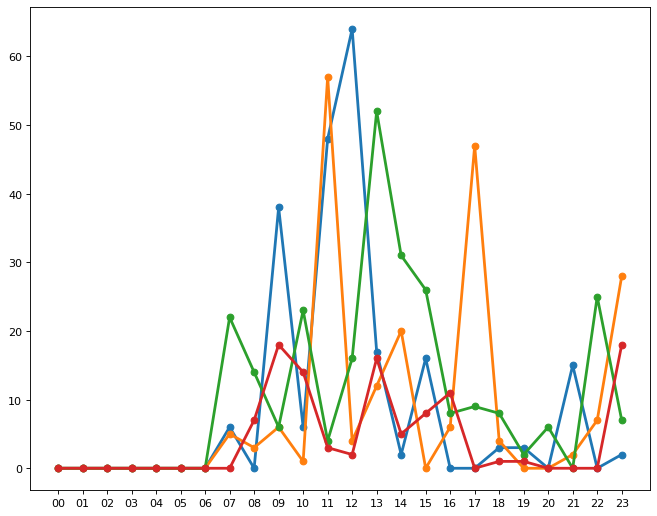

In [46]:
# TODO: 1. add some explanation to the plot: title, labels for axises, maybe legend. Now it tells nothing
# TODO: 2. fix KeyError: '24'


figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
fig = go.Figure()

for i in range(7):
    date_before = datetime.datetime(2020, 8, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID)

    fig.add_trace(go.Bar(
        y=x,
        x=y,
        name="{}-08-2020".format(4 + i),
        orientation='h',
        marker=dict(
            line=dict(color='rgb(105, 105, 105, 1.0)', width=3)
        )
    ))
    plt.plot(x, y, linewidth=2.5, marker='o', linestyle="-", label="{}-08-2020".format(4 + i))

plt.xticks([i for i in range(0, 24)])
plt.legend(loc='upper left', frameon=False)
plt.show()

# show comparing bar
fig.update_layout(
    barmode='stack',
    autosize=False,
    width=800,
    height=800,
    yaxis = dict(
            title='Hours',
            titlefont_size=16,
            tickfont_size=14,
            tickmode = 'array',
            tickvals = [i for i in range(24)]),
    xaxis = dict(
            title='Number of messages',
            titlefont_size=16,
            tickfont_size=14)
)
fig.show()

## Top people with whom communicate during 10.06.2020 - 09.08.2020

In [48]:
# TODO: are these recived messages? or sent? can you pls give statistics for both(sent and recived). store this in the dataframe

date_before = datetime.datetime(2017, 1, 10, 0, 0, 0)
date_after = datetime.datetime(2020, 8, 10, 0, 0, 0)

x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID, "top_friends")
for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

1 place is Andrew Kurochkin with 883 messages
2 place is Anastasia Mazur with 674 messages
3 place is –°–∞—à–∞ –£–∫—É with 672 messages
4 place is –ú–∞–∫—Å –®–∫ with 667 messages
5 place is –í—ñ—Ç—è –ü–µ—Ä—É–∫–∞—Ä with 650 messages
6 place is –ö–æ–Ω—Å—Ç—è–Ω—Ç–∏–Ω –ë–æ—Ö–∞–Ω with 639 messages
7 place is –¢–∞—Ä–∞—Å–æ–Ω –õ—ñ–ø—à–∏–π with 617 messages
8 place is –†–æ–º–∞–Ω –ú–æ–π—Å–µ—î–≤ with 611 messages
9 place is –ë–æ–≥–¥–∞–Ω –ú–∞—Ç–≤—ñ—ó–≤ with 606 messages
10 place is –û–ª–µ–≥ –ö–∞–º–µ—Ä–∞ with 598 messages
11 place is Anastasia Khaburska with 587 messages
12 place is –û–ª–µ–∫—Å—ñ–π with 576 messages
13 place is –Æ–ª—è with 567 messages
14 place is Oleh UCU with 562 messages
15 place is –û–ª–µ–≥ –û–Ω–∏—â–∞–∫ with 562 messages
16 place is –ì—Ä–æ—Ü—å–∫–∏–π –î with 561 messages
17 place is –ê–Ω–¥—Ä—ñ–π –†–æ–º–∞–Ω—á–∞–∫ with 558 messages
18 place is –Ø—Ä–µ–º–∞ –°—ñ—Ä—Å—å–∫–∏–π with 546 messages
19 place is Ivan Prodaiko with 544 messages
20 place is –ö—É–∫—É—Ä—É–∑ with 544 messages
21 pla

In [ ]:
# TODO: add same calculations for number of words. add it to the same dataframe

## Top groups with whom communicate during 10.06.2020 - 09.08.2020

In [44]:
x, y, lists = get_user_activity(dialogs_info, date_before, date_after, "Group", USER_ID, "top_friends")

for place, friend in enumerate(lists.items()):
    print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))

1 place is —Å–µ–∫—Ä–µ—Ç–Ω–∏–π —á–∞—Ç with 497 messages
2 place is rasta420 with 490 messages
3 place is ds18+ with 355 messages
4 place is curilca_UCU with 311 messages
5 place is –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ –∑ –û–ª–µ—é with 142 messages
6 place is –î–∏–∑–∞–π–Ω –ö–∞—Ä–ø–∞—Ç—Å—å–∫–∞ with 128 messages
7 place is A&S&P(&A) 13/05 with 87 messages
8 place is F12 with 85 messages
9 place is lohika_ucu with 77 messages
10 place is –ø—è—Ç–Ω–∏—á–Ω—ñ –¥–≤—ñ–∂–∞ with 76 messages
11 place is tmp with 71 messages
12 place is d2v with 65 messages
13 place is 12/05 Ph&A flat with 58 messages
14 place is –ü'—è—Ç–Ω–∏—Ü—è üç∫üç∫üç∫ with 40 messages
15 place is SunPhoto with 35 messages
16 place is Modern & Concept photography ONLINE (summer 2020) with 31 messages
17 place is —ñ–¥ –∫–∞—Ä—Ç–∫–∞ with 23 messages
18 place is text_review with 22 messages
19 place is KT with 19 messages
20 place is –û–û–ê with 16 messages
21 place is –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ with 16 messages
22 place is 

## Time spending on conversations during 03.08.2020 - 09.08.2020

KEYERROR!!! 88
Time spend on conversation: dialog Controller Bot 11.0 minutes
Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog –¢–∞–¥—ñ–∫ –í—ñ—Ç—ñ–Ω 10.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –°–∞–±—ñ–Ω—ñ—á 0.0 minutes
Time spend on conversation: dialog –ê–Ω—Ñ–∏—Å–∞ –ö—Ä–∞—Å–∞ –∏ –°–∫–∞–∑–æ—á–Ω—ã–µ –ß—É–¥–µ—Å–∞ 0.0 minutes
Time spend on conversation: dialog Anton 0.0 minutes
Time spend on conversation: dialog Anton Shcherbyna 37.0 minutes
Time spend on conversation: dialog –õ—î–≤–∏–π 0.0 minutes
KEYERROR!!! 106
Time spend on conversation: dialog –ë–æ–≥–¥–∞–Ω–∞ –ú–∏–∫–∏—Ç—é–∫ 16.0 minutes
KEYERROR!!! 35
Time spend on conversation: dialog –°—Ç–µ–ø–∞–Ω –Ñ—Ä–æ—à–µ–Ω–∫–∞ 6.0 minutes
Time spend on conversation: dialog –û–ª–µ—Å—å –£–∫—É 21.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –ó–∞–ø–æ—Ç—ñ—á–Ω–∏–π 0.0 minutes
Time spend on conversation: dialog –ü—Ä–∏–≤–∞—Ç–ë–∞–Ω–∫–ë–æ—Ç 0.0 minutes
Time spend on conversation: dialog –ù–∞—

KEYERROR!!! 163
Time spend on conversation: dialog Yulia Dov 35.0 minutes
Time spend on conversation: dialog –ê–ª–µ–∫—Å–µ–π –ó–∞–ª 148.0 minutes
Time spend on conversation: dialog Maxym 0.0 minutes
Time spend on conversation: dialog Diana Nikitina 62.0 minutes
KEYERROR!!! 180
Time spend on conversation: dialog –¢–∞—Ä–∞—Å –î–∏–∑–∞–π–Ω 21.0 minutes
Time spend on conversation: dialog –Æ–ª—è 236.0 minutes
Time spend on conversation: dialog Serhii Tiutiunnyk 2.0 minutes
Time spend on conversation: dialog Anastasiia 0.0 minutes
Time spend on conversation: dialog –ö—É—Ä–∞—Ç–æ—Ä –ö–æ—Ä–æ–ª—å 0.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –Ñ–ë–†–† 0.0 minutes
Time spend on conversation: dialog –í–∞—Å—Ç—Ä–∏–∫ 0.0 minutes
Time spend on conversation: dialog –ñ–µ–Ω—è –¢–∞—Ä–∞—Å–∞ 0.0 minutes
KEYERROR!!! 277
Time spend on conversation: dialog –ù–∞—Å—è –ö—É—á–µ—Ä—è–≤–∞ 57.0 minutes
Time spend on conversation: dialog europrice 0.0 minutes
Time spend on conversation: dialog Sasha Lozinskyi

Time spend on conversation: dialog B-Day Trip 31.05-03.06 0.0 minutes
Time spend on conversation: dialog –ü'—è—Ç–Ω–∏—Ü—è üç∫üç∫üç∫ 11.0 minutes
Time spend on conversation: dialog –ø–µ—Ä–µ–∫—É—Ä—â–∏–∫–∏ –ö–∏–µ–≤ 0.0 minutes
Time spend on conversation: dialog 123 0.0 minutes
Time spend on conversation: dialog lohika_ucu 29.0 minutes
KEYERROR!!! 2
Time spend on conversation: dialog XXX Morning@Lohika 04.04.2020 0.0 minutes
Time spend on conversation: dialog Heralds of Spring 0.0 minutes
Time spend on conversation: dialog Finance Project [UCU] 0.0 minutes
Time spend on conversation: dialog SunPhoto 0.0 minutes
Time spend on conversation: dialog ds18+ 103.0 minutes
Time spend on conversation: dialog –ê—Ö—É—î–≤—à–∏–π –¥–≤—ñ–∂ –≤ –ê–ö –Ω–∞ –±–∞–∑—ñ, –ø—ñ—Å–ª—è –ù–† 0.0 minutes
Time spend on conversation: dialog –ø–æ–¥–∞—Ä–æ–∫ 0.0 minutes
Time spend on conversation: dialog Morning @ Lohika(26/01/2019) 0.0 minutes
Time spend on conversation: dialog Morning B-thday #5 0.0 minutes
KEYERROR!!! 

Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –î–∏–º–æ—Ö–æ–¥–∏ 0.0 minutes
Time spend on conversation: dialog Olha Hnativ 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Olha N 157.0 minutes
Time spend on conversation: dialog –ú–∏–∫–æ–ª–∞ –ú–∞–∫—Å–∏–º–µ–Ω–∫–æ 10.0 minutes
Time spend on conversation: dialog –ù–∞—Ç–∞–ª—è –£–ö–£ 0.0 minutes
Time spend on conversation: dialog Mykola Kolinko 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog –°–∞—à–∞ –£–∫—É 215.0 minutes
Time spend on conversation: dialog Munim ahmed ( Freelance Web & Software developer) 0.0 minutes
KEYERROR!!! 155
Time spend on conversation: dialog –î–∞—Ä–∫–æ –†–µ—Ü–µ–Ω—Ç 28.0 minutes
Time spend on conversation: dialog Nazar Pawliuk 0.0 minutes
Time spend on conversation: dialog Lingvo 0.0 minutes
Time spend on conversation: dialog Felix Uber 0.0 minutes
Time spend on conversation: dialog Chekachkov academy 4.0 minutes
Time spend on conversation: dialog –û–ª–µ–≥ –û–Ω–∏—â–∞–∫ 35.0 minutes
Time

Time spend on conversation: dialog “ê–∞–π–∑—É–Ω–∏ 2.0 minutes
Time spend on conversation: dialog –ü—Ä–∞–∂—Å–∫–∏–π –≤–µ—á–µ—Ä 0.0 minutes
Time spend on conversation: dialog y 0.0 minutes
Time spend on conversation: dialog Sax 0.0 minutes
Time spend on conversation: dialog –î–ù –û–ª–µ–≥–∞ 0.0 minutes
Time spend on conversation: dialog –ü–æ–¥–∞—Ä—É–Ω–æ–∫ –°–∞–Ω–∏—á—É 0.0 minutes
Time spend on conversation: dialog —ñ–¥ –∫–∞—Ä—Ç–∫–∞ 6.0 minutes
Time spend on conversation: dialog Monday: beer and good talks 0.0 minutes
KEYERROR!!! 110
Time spend on conversation: dialog 12/05 Ph&A flat 27.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog —Å–µ–∫—Ä–µ—Ç–Ω–∏–π —á–∞—Ç 197.0 minutes
KEYERROR!!! 167
Time spend on conversation: dialog –ø—è—Ç–Ω–∏—á–Ω—ñ –¥–≤—ñ–∂–∞ 21.0 minutes
Time spend on conversation: dialog Box&MJ 0.0 minutes
Time spend on conversation: dialog 18.05.19 —Å—Ç—É–¥–µ–Ω—Ç—Å—å–∫–µ –∂–∏—Ç—Ç—è 2.0 0.0 minutes
Time spend on conversation: dialog 3 –ª—ñ—Ç–Ω—ñ –∫–≤—ñ—Ç–æ—á–∫–∏ 0.0 

Time spend on conversation: dialog –û–ª–µ–≥ –ö–∞–º–µ—Ä–∞ 170.0 minutes
Time spend on conversation: dialog –í–µ—Ä–æ–Ω—ñ–∫–∞ –°—Ç–∞—Ä–æ—Å—Ç–∞ 0.0 minutes
Time spend on conversation: dialog Vadym Korshunov 0.0 minutes
Time spend on conversation: dialog –ü–∞—Ä—è 0.0 minutes
KEYERROR!!! 2
Time spend on conversation: dialog Max Ostrozhinskiy 0.0 minutes
Time spend on conversation: dialog Yuriy Lizak 0.0 minutes
Time spend on conversation: dialog Helga K 6.0 minutes
Time spend on conversation: dialog Y Œ®RII Œ®ŒûLŒπSIE I-3V 0.0 minutes
Time spend on conversation: dialog –õ—ñ—Å–∞–ø—î–¥ –¢—å–æ–º–∞ 0.0 minutes
Time spend on conversation: dialog –í—ñ—Ç–∞–ª—ñ–π –ö–æ–ª–µ–≥–∞ 8.0 minutes
Time spend on conversation: dialog roma cayman 0.0 minutes
Time spend on conversation: dialog Andrii 7.0 minutes
Time spend on conversation: dialog –û–ª–µ–∫—Å–∞–Ω–¥—Ä –ü–∞—Ä—É–±—ñ–π 18.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –†–µ–≤—ñ–Ω 7.0 minutes
Time spend on conversation: dialog –Ü–≤–∞–Ω –í–µ—Ä–

Time spend on conversation: dialog –¢–∞—Ä–∞—Å–æ–Ω –õ—ñ–ø—à–∏–π 18.0 minutes
Time spend on conversation: dialog –û–ª–µ–∫—Å—ñ–π –ö–∞—Ä–∑–æ–≤ 1.0 minutes
Time spend on conversation: dialog –í–æ–≤–∞ –õ—É–Ω 0.0 minutes
Time spend on conversation: dialog Vitalii 1.0 minutes
Time spend on conversation: dialog –Ü–≥–æ—Ä –ë–∞–Ω–∞–¥—ñ–≥–∞ 23.0 minutes
Time spend on conversation: dialog –û–ª–µ–∫—Å—ñ–π –ú—É–∑–∏–∫–∞–Ω—Ç 0.0 minutes
Time spend on conversation: dialog Valerii 0.0 minutes
Time spend on conversation: dialog Volodymyr Kondratenko RLR COO 0.0 minutes
Time spend on conversation: dialog –¢–µ–æ–¥–æ—Ä –£–ö–£ 0.0 minutes
Time spend on conversation: dialog –§–æ—Ç–æ–≤—Ä–∞–º–∫–µ 1.0 minutes
Time spend on conversation: dialog Dmytro Babenko 6.0 minutes
Time spend on conversation: dialog Nazarii Nyzhnyk 0.0 minutes
Time spend on conversation: dialog –°–æ–ª–æ–º—ñ—è 0.0 minutes
KEYERROR!!! 47
Time spend on conversation: dialog –°–æ–ª—è –ì–Ω—ñ–¥–µ—Ü—å (–õ–æ–≥—ñ–∫–∞) 9.0 minutes
Time spend on conversat

Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog –¢–∞–¥—ñ–∫ –í—ñ—Ç—ñ–Ω 10.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –°–∞–±—ñ–Ω—ñ—á 0.0 minutes
Time spend on conversation: dialog –ê–Ω—Ñ–∏—Å–∞ –ö—Ä–∞—Å–∞ –∏ –°–∫–∞–∑–æ—á–Ω—ã–µ –ß—É–¥–µ—Å–∞ 0.0 minutes
Time spend on conversation: dialog Anton 0.0 minutes
Time spend on conversation: dialog Anton Shcherbyna 37.0 minutes
Time spend on conversation: dialog –õ—î–≤–∏–π 0.0 minutes
KEYERROR!!! 106
Time spend on conversation: dialog –ë–æ–≥–¥–∞–Ω–∞ –ú–∏–∫–∏—Ç—é–∫ 16.0 minutes
KEYERROR!!! 35
Time spend on conversation: dialog –°—Ç–µ–ø–∞–Ω –Ñ—Ä–æ—à–µ–Ω–∫–∞ 6.0 minutes
Time spend on conversation: dialog –û–ª–µ—Å—å –£–∫—É 21.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –ó–∞–ø–æ—Ç—ñ—á–Ω–∏–π 0.0 minutes
Time spend on conversation: dialog –ü—Ä–∏–≤–∞—Ç–ë–∞–Ω–∫–ë–æ—Ç 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog –ù–∞—Å—Ç—è –•–æ–º–∞ 77.0 minutes
KEYERROR!!! 123
Time spend on con

Time spend on conversation: dialog Oleg Dats 3.0 minutes
KEYERROR!!! 31
Time spend on conversation: dialog Mary 4.0 minutes
Time spend on conversation: dialog Modest 0.0 minutes
Time spend on conversation: dialog Vlad 0.0 minutes
Time spend on conversation: dialog –í–æ–≤–∞ –õ–æ–≥—ñ–∫–∞ 24.0 minutes
KEYERROR!!! 39
Time spend on conversation: dialog –†–æ–º–∞–Ω –†–æ–¥–∏—á –Ü–¢ –∞—É—Ç—Å–æ—Ä—Å 4.0 minutes
Time spend on conversation: dialog Serge Bishyr 15.0 minutes
Time spend on conversation: dialog –ì–æ–≥—ñ –ö–∏—ó–≤ 0.0 minutes
Time spend on conversation: dialog Anton Mi 0.0 minutes
Time spend on conversation: dialog –ö–æ—Å—Ç—è –î–∞—Ç–∞—Å–∞–π–Ω 44.0 minutes
Time spend on conversation: dialog Yuliia 0.0 minutes
Time spend on conversation: dialog Danylo Kolinko 0.0 minutes
Time spend on conversation: dialog Serhii Brodiuk 0.0 minutes
Time spend on conversation: dialog Oleksii Boiko 0.0 minutes
Time spend on conversation: dialog Ann Karachevska 7.0 minutes
Time spend on conversation: dialog –

Time spend on conversation: dialog d2v 9.0 minutes
Time spend on conversation: dialog Movies üçø 0.0 minutes
Time spend on conversation: dialog –ü–∞—Ç—ñ –Ω–∞ —Ö–∞—Ç—ñ 0.0 minutes
Time spend on conversation: dialog –ö–∏—ó–≤ –õ—å–≤—ñ–≤ 0.0 minutes
Time spend on conversation: dialog –ë—É—Ä—Å–∞, 43–ø–∑ 0.0 minutes
Time spend on conversation: dialog MMDS trenders 0.0 minutes
Time spend on conversation: dialog Goodfellas 0.0 minutes
Time spend on conversation: dialog The boys and the girls 0.0 minutes
Time spend on conversation: dialog –ë–æ–∫—Å 0.0 minutes
Time spend on conversation: dialog OUR NEXT TRIP 0.0 minutes
Time spend on conversation: dialog –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ –∑ –û–ª–µ—é 43.0 minutes
Time spend on conversation: dialog –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ 4.0 minutes
Time spend on conversation: dialog Kiev organic weekend 0.0 minutes
KEYERROR!!! 4
Time spend on conversation: dialog AK film [dev] 0.0 minutes
Time spend on conversation: dialog B-Day Trip 31.05-03.06 0

KEYERROR!!! 1000
Time spend on conversation: dialog Olha N 157.0 minutes
Time spend on conversation: dialog –ú–∏–∫–æ–ª–∞ –ú–∞–∫—Å–∏–º–µ–Ω–∫–æ 10.0 minutes
Time spend on conversation: dialog –ù–∞—Ç–∞–ª—è –£–ö–£ 0.0 minutes
Time spend on conversation: dialog Mykola Kolinko 0.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog –°–∞—à–∞ –£–∫—É 215.0 minutes
Time spend on conversation: dialog Munim ahmed ( Freelance Web & Software developer) 0.0 minutes
KEYERROR!!! 155
Time spend on conversation: dialog –î–∞—Ä–∫–æ –†–µ—Ü–µ–Ω—Ç 28.0 minutes
Time spend on conversation: dialog Nazar Pawliuk 0.0 minutes
Time spend on conversation: dialog Lingvo 0.0 minutes
Time spend on conversation: dialog Felix Uber 0.0 minutes
Time spend on conversation: dialog Chekachkov academy 4.0 minutes
Time spend on conversation: dialog –û–ª–µ–≥ –û–Ω–∏—â–∞–∫ 35.0 minutes
Time spend on conversation: dialog Olena Shevchenko 24.0 minutes
Time spend on conversation: dialog Anna Nortsova 6.0 minutes
Time spend on 

Time spend on conversation: dialog 3 –ª—ñ—Ç–Ω—ñ –∫–≤—ñ—Ç–æ—á–∫–∏ 0.0 minutes
KEYERROR!!! 131
Time spend on conversation: dialog tmp 21.0 minutes
Time spend on conversation: dialog –Ø—Ä–∫–æ –ø–æ–¥–∞—Ä–æ–∫, –∫—ñ—Å–ª–æ—Ç–∞_247 0.0 minutes
KEYERROR!!! 24
Time spend on conversation: dialog –û–û–ê 3.0 minutes
Time spend on conversation: dialog –®–æ–∫–æ–ª–∞–¥–Ω–∏–π –ü–∞–∫—î—Ç—ñ–∫ 0.0 minutes
KEYERROR!!! 6
Time spend on conversation: dialog Lv:v F:lm People 2.0 minutes
Time spend on conversation: dialog Berlin weed crusade 0.0 minutes
Time spend on conversation: dialog Party in the zoo 0.0 minutes
Time spend on conversation: dialog "I am the gift" 0.0 minutes
Time spend on conversation: dialog APPS@UCU (–≤—Å—ñ) ‚ù§Ô∏è 0.0 minutes
Time spend on conversation: dialog UCUKyiv 0.0 minutes
Time spend on conversation: dialog ODS: AskMeAnything 0.0 minutes
Time spend on conversation: dialog  0.0 minutes
Time spend on conversation: dialog top performers 0.0 minutes
Time spend on conversation: dialog Fe

KEYERROR!!! 1000
Time spend on conversation: dialog –ì—Ä–æ—Ü—å–∫–∏–π –î 172.0 minutes
KEYERROR!!! 16
Time spend on conversation: dialog –î–∞–Ω–∞ –Ü—â—É–∫ üî• 1.0 minutes
Time spend on conversation: dialog –û–ª–µ–∫—Å—ñ–π WIX 0.0 minutes
KEYERROR!!! 33
Time spend on conversation: dialog –£–ö–†–ü–û–®–¢–ê 1.0 minutes
KEYERROR!!! 234
Time spend on conversation: dialog –Æ–ª—è –¢—ñ–Ω–¥–µ—Ä 58.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –†–æ–º–∞–Ω—á–∞–∫ 0.0 minutes
Time spend on conversation: dialog –ú–∞—Ä'—è–Ω–∞ –†–æ–º–∞–Ω–∏—à–∏–Ω 9.0 minutes
Time spend on conversation: dialog L 0.0 minutes
Time spend on conversation: dialog –ù–∞—Å—Ç—è –ù—ñ–∫–∞ 0.0 minutes
Time spend on conversation: dialog Dmytro Shylov 2.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä–æ–Ω –ú–∞–ª–∏–π 0.0 minutes
Time spend on conversation: dialog Anton Skrypnyk 0.0 minutes
Time spend on conversation: dialog Bob Marley 0.0 minutes
Time spend on conversation: dialog –ñ–µ–∫–∞ –ü–æ–∑–¥–Ω—è–∫–æ–≤ 51.0 minutes

Time spend on conversation: dialog –ñ–µ–Ω—è –ê–π–æ 68.0 minutes
Time spend on conversation: dialog Sophie Pashko 0.0 minutes
Time spend on conversation: dialog –•—Ä–∏—Å—Ç—è 4.0 minutes
Time spend on conversation: dialog –û–ª–µ–Ω–∞ –ú—É–∑–∏–∫–∞ –£–ö–£ 0.0 minutes
Time spend on conversation: dialog –°–∞—à–∞ –î–∞—Ç–∞—Å–∞–π–Ω—Å 67.0 minutes
KEYERROR!!! 19
Time spend on conversation: dialog 1319botDev 1.0 minutes
KEYERROR!!! 27
Time spend on conversation: dialog Dasha Vishniveckaya 4.0 minutes
Time spend on conversation: dialog üö¨ –ö—É—Ä–∏–ª—å—â–∏–∫–∏ 0 minutes
Time spend on conversation: dialog –ù–æ–≤–∞ –Ω–∞–∑–≤–∞ –≥—Ä—É–ø–∏ 0 minutes
Time spend on conversation: dialog L.420 0 minutes
Time spend on conversation: dialog 23.09.1996 0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog curilca_UCU 106.0 minutes
KEYERROR!!! 172
Time spend on conversation: dialog F12 23.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog rasta420 159.0 minutes
Time spend on conversation: dia

Time spend on conversation: dialog –ë–æ–≥–¥–∞–Ω –ú–∞—Ç–≤—ñ—ó–≤ 206.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog –†–æ–º–∞–Ω –ú–æ–π—Å–µ—î–≤ 172.0 minutes
Time spend on conversation: dialog Tonia Chundak 1.0 minutes
Time spend on conversation: dialog Anton Parfeniuk 0.0 minutes
Time spend on conversation: dialog –¢–∞—Ä–∞—Å –ú–∞—Ç—è—à–æ–≤—Å—å–∫–∏–π 0.0 minutes
Time spend on conversation: dialog HashTag 0.0 minutes
Time spend on conversation: dialog –û–ª–µ–∫—Å—ñ–π 183.0 minutes
Time spend on conversation: dialog Oleg Khromov 0.0 minutes
Time spend on conversation: dialog –ú–ª–∏–Ω–∫–æ 0.0 minutes
Time spend on conversation: dialog Andriy Gazin 0.0 minutes
KEYERROR!!! 102
Time spend on conversation: dialog BotFather 12.0 minutes
KEYERROR!!! 1000
Time spend on conversation: dialog Anastasia Khaburska 222.0 minutes
Time spend on conversation: dialog Ivan Prodaiko 84.0 minutes
Time spend on conversation: dialog –ú–∞—Ä–∏–Ω–∞ –õ–æ–≥—ñ–∫–∞–Ω–∫–∞ 0.0 minutes
Time spend on conversati

Time spend on conversation: dialog –Æ–ª—è 236.0 minutes
Time spend on conversation: dialog Serhii Tiutiunnyk 0.0 minutes
Time spend on conversation: dialog Anastasiia 0.0 minutes
Time spend on conversation: dialog –ö—É—Ä–∞—Ç–æ—Ä –ö–æ—Ä–æ–ª—å 0.0 minutes
Time spend on conversation: dialog –ê–Ω–¥—Ä—ñ–π –Ñ–ë–†–† 0.0 minutes
Time spend on conversation: dialog –í–∞—Å—Ç—Ä–∏–∫ 0.0 minutes
Time spend on conversation: dialog –ñ–µ–Ω—è –¢–∞—Ä–∞—Å–∞ 0.0 minutes
KEYERROR!!! 277
Time spend on conversation: dialog –ù–∞—Å—è –ö—É—á–µ—Ä—è–≤–∞ 57.0 minutes
Time spend on conversation: dialog europrice 0.0 minutes
Time spend on conversation: dialog Sasha Lozinskyi 8.0 minutes
Time spend on conversation: dialog –õ–µ–Ω–∞ –•–∞—Ç–∞ 0.0 minutes
Time spend on conversation: dialog –ù—ñ–∫ 175.0 minutes
Time spend on conversation: dialog –ú–∞–∫—Å –®–∫ 72.0 minutes
Time spend on conversation: dialog –í–æ–≤–∞ –û—Ñ—ñ—Å 0.0 minutes
Time spend on conversation: dialog Alexander Kataev 0.0 minutes
Time spend on conversati

Time spend on conversation: dialog d2v 23.0 minutes
Time spend on conversation: dialog Movies üçø 0.0 minutes
Time spend on conversation: dialog –ü–∞—Ç—ñ –Ω–∞ —Ö–∞—Ç—ñ 0.0 minutes
Time spend on conversation: dialog –ö–∏—ó–≤ –õ—å–≤—ñ–≤ 0.0 minutes
Time spend on conversation: dialog –ë—É—Ä—Å–∞, 43–ø–∑ 0.0 minutes
Time spend on conversation: dialog MMDS trenders 0.0 minutes
Time spend on conversation: dialog Goodfellas 0.0 minutes
Time spend on conversation: dialog The boys and the girls 0.0 minutes
Time spend on conversation: dialog –ë–æ–∫—Å 0.0 minutes
Time spend on conversation: dialog OUR NEXT TRIP 0.0 minutes
Time spend on conversation: dialog –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ –∑ –û–ª–µ—é 43.0 minutes
Time spend on conversation: dialog –ö–∞—Ä–∞–Ω—Ç–∏–Ω–Ω–∞ —á–≤–µ—Ä—Ç–∫–∞ 4.0 minutes
Time spend on conversation: dialog Kiev organic weekend 0.0 minutes
KEYERROR!!! 4
Time spend on conversation: dialog AK film [dev] 0.0 minutes
Time spend on conversation: dialog B-Day Trip 31.05-03.06 

<Figure size 1280x1120 with 0 Axes>

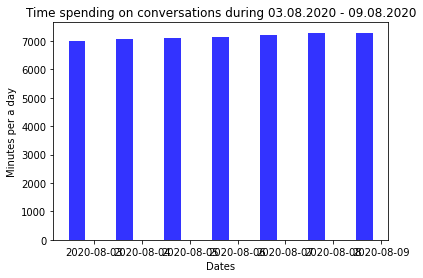

In [52]:
# TODO: it's not okay to have so mane KEYERROR!!!s, something in the logic is wrong
# table with time spend on the dialog should be in the dataframe
# when I dwar chart for long time period(7 months) I see same bars, with values 7000minutes per day, are you sure it's okay?
    
plot_data = {}
for i in range(7):
    date_before = datetime.datetime(2020, 1, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    general_dialog_time = get_user_activity(dialogs_info, date_before, date_after, "Private dialog", USER_ID, "active_minutes") \
                          + get_user_activity(dialogs_info, date_before, date_after, "Group", USER_ID, "active_minutes")
    plot_data[datetime.date(2020, 8, 3 + i)] = general_dialog_time

print(plot_data)
lists = sorted(plot_data.items())
dates, n_minutes_lst = zip(*lists)

n_days = 7

# create plot
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots()
index = np.arange(n_days)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, n_minutes_lst, bar_width,
alpha=opacity,
color='b')

plt.xlabel('Dates')
plt.ylabel('Minutes per a day')
plt.title('Time spending on conversations during 03.08.2020 - 09.08.2020')
plt.xticks(index + bar_width, dates)

plt.show()